In [ ]:
'''
动态规划算法要求马尔可夫决策过程是已知的，即要求与智能体交互的环境是完全已知的（例如迷宫或者给定规则的网格世界）。
在此条件下，智能体其实并不需要和环境真正交互来采样数据，直接用动态规划算法就可以解出最优价值或策略。
'''

In [ ]:
'''
对于大部分强化学习现实场景（例如电子游戏或者一些复杂物理环境），其马尔可夫决策过程的状态转移概率是无法写出来的，也就无法直接进行动态规划。
在这种情况下，智能体只能和环境进行交互，通过采样到的数据来学习，
这类学习方法统称为无模型的强化学习（model-free reinforcement learning）。
'''

In [ ]:
'''
不同于动态规划算法，无模型的强化学习算法不需要事先知道环境的奖励函数和状态转移函数，
而是直接使用和环境交互的过程中采样到的数据来学习，这使得它可以被应用到一些简单的实际场景中
'''

In [ ]:
'''
本章将要讲解无模型的强化学习中的两大经典算法：Sarsa 和 Q-learning，它们都是基于时序差分（temporal difference，TD）的强化学习算法。
'''

In [ ]:
# 在线策略学习
# 在线策略学习要求使用在当前策略下采样得到的样本进行学习，一旦策略被更新，当前的样本就被放弃了

# 离线策略学习
# 离线策略学习使用经验回放池将之前采样得到的样本收集起来再次利用

In [ ]:
'''
时序差分是一种用来估计一个策略的价值函数的方法，它结合了蒙特卡洛和动态规划算法的思想。
'''
# 时序差分方法 和 蒙特卡洛 的相似之处在于 可以从样本数据中学习，不需要事先知道环境
# 时序差分方法 和 动态规划 的相似之处在于 根据贝尔曼方程的思想，利用后续状态的价值估计来更新当前状态的价值估计

In [ ]:
'''
蒙特卡洛方法必须要等整个序列结束之后才能计算得到这一次的回报Gt，
而时序差分方法只需要当前步结束即可进行计算
'''

 时序差分算法用当前获得的奖励加上下一个状态的价值估计来作为在当前状态会获得的回报，即：
 $ V(s_t) <-  V(s_t) + α[r_t + γV(s_t+1) -V(s_t)]$


其中 $ R_t + γV(s_t+1) -V(s_t)$  被成为TD error,TD误差

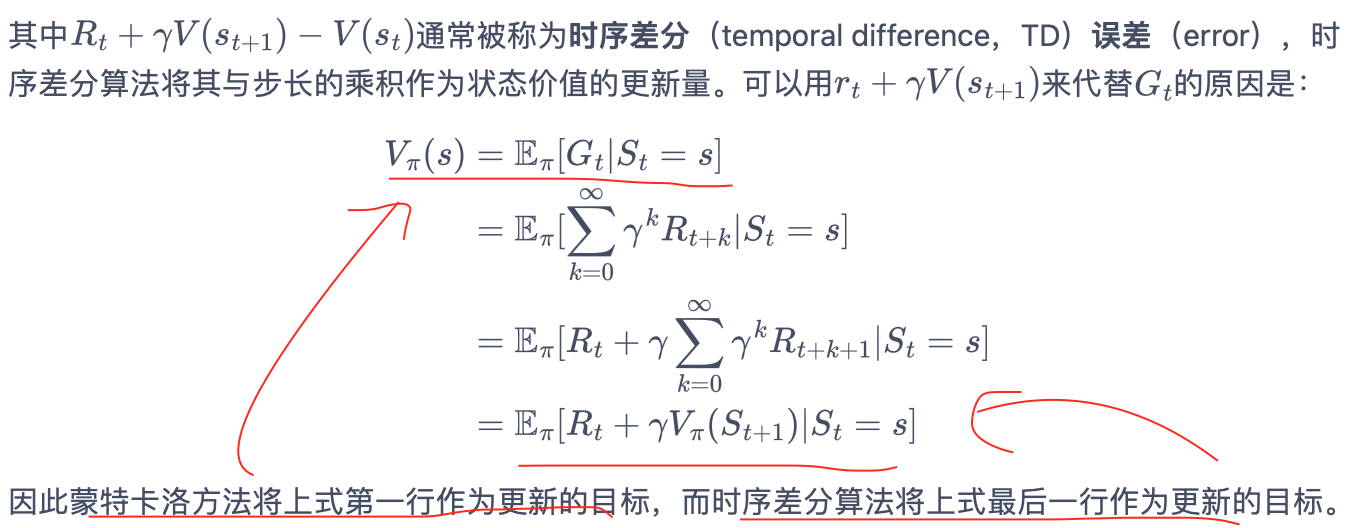

In [1]:
from IPython.display  import Image
Image(filename='./image/td.png',width=600)

In [ ]:
'''
时序才分用到了V(st+1)的估计，可以证明它最终收敛到策略π的价值函数
'''


In [ ]:
'''
Sarsa算法
'''
# 策略评估已经可以通过时序差分算法实现，那么在不知道奖励函数和状态转移函数的情况下该怎么进行策略提升呢？
# 答案是：可以直接用时序差分算法来估计动作价值函数Q：

$Q(s_t,a_t) ← Q(s_t,a_t) + α[r_t + γQ(s_{t+1},a_{t+1}) - Q(s_t,a_t)]$

然后，我们用贪婪算法选取在某个状态下动作价值最大的动作，即 $argmax_a{Q(s,a)}$

这样似乎已经形成了一个完整的强化学习算法:用贪婪算法根据动作价值选出动作a和环境交互，再根据得到的数据用时序拆分算法更新动作价值估计。

In [ ]:
'''
需要进一步考虑以下两点：
'''
# 第一：
# 如果要用时序差分算法来准确地估计策略的状态价值函数，我们需要用极大量的样本来进行更新。
# 但实际上我们可以忽略这一点，直接用一些样本来评估策略，然后就可以更新策略了。
# 我们可以这么做的原因是策略提升可以在策略评估未完全进行的情况进行。

#第二：
# 如果在策略提升中一直根据贪婪算法得到一个确定性策略，可能会导致某些状态动作对(s,a)永远不会在序列中出现，
# 以至于无法对其动作价值进行估计，进而无法保证策略提升后的策略比之前的好

'''
简单的常用解决方案是不在只使用贪婪算法，而采用epsilon-贪婪策略:
'''


# 单步 Sarsa 算法 --是在线策略算法

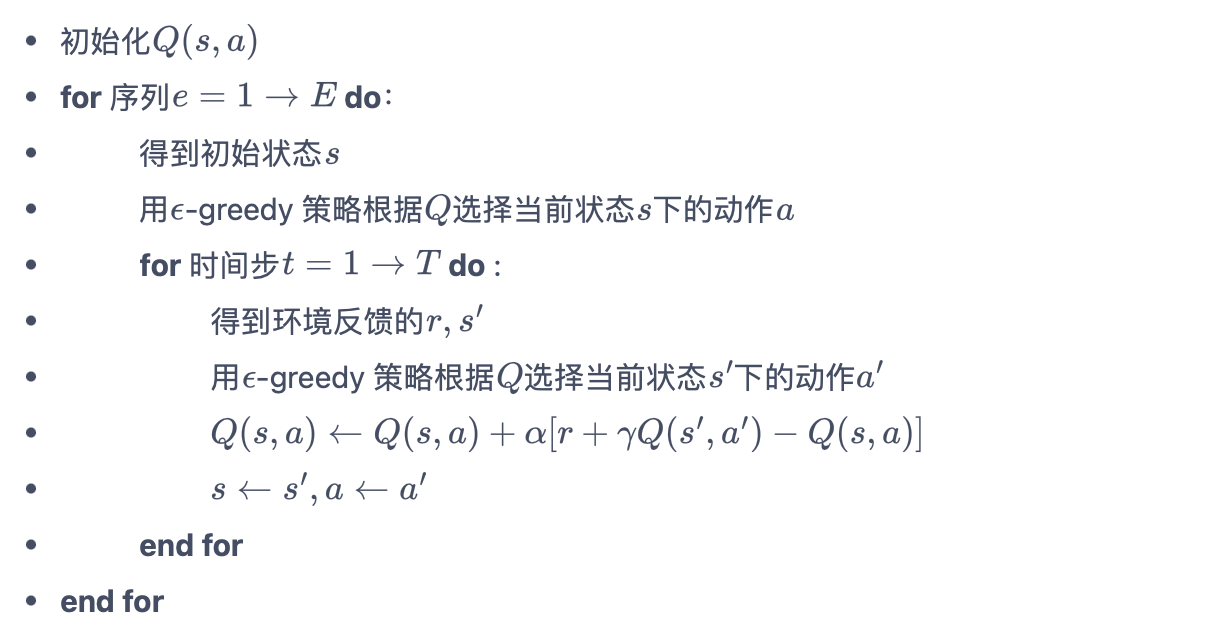

In [2]:
# sarsa算法的具体流程
Image(filename="./image/sarsa.png",width=600)

In [4]:
# 我们仍然在”悬崖漫步“环境中尝试Sarsa算法。但是和之前的代码不一样，因为此时环境不再需要提供 奖励含糊和状态转移函数。
'''
而需要提供一个和智能体进行交互的函数step()，该函数将智能体的动作作为输入，输出奖励和下一个状态给智能体
'''

'\n而需要提供一个和智能体进行交互的函数step()，该函数将智能体的动作作为输入，输出奖励和下一个状态给智能体\n'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# 无环境模型的”悬崖漫步“
class WalkingEnv:
    def __init__(self,ncol,nrow):
        self.ncol = ncol
        self.nrow = nrow
        self.x = 0 # 记录当前智能体的横坐标
        self.y = self.nrow - 1 # 记录当前智能体位置的纵坐标
        
    def step(self,action): # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。
        # 坐标原点(0,0)在左上角
        change = [[0,-1],[0,1],[-1,0],[1,0]]
        
        # change[action][0] 是 x 方向的变化，change[action][1] 是 y 方向的变化。
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        
        next_state = self.y * self.ncol + sel.x
        reward  = -1
        
        done = False
        # 下一个位置在悬崖或者目标
        if self.y == self.nrow-1 and self.x >0 :# 到达最后一行，不在第一列
            done = True
            if self.x != self.ncol -1:
                reward = -100
        return next_state,reward,done
    
    def reset(self): # 回归初始状态，坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow -100
        return self.y * self.ncol + self.x
    

In [ ]:
'''
实现 Sarsa 算法，主要维护一个表格Q_table()，用来储存当前策略下所有状态动作对的价值，
'''
# 在更新sarsa时，使用时序拆分公式。
# 我们默认终止状态时所有动作的价值都是0

class Sarsa:
    def __init__(self,ncol,nrow,epsilon,alpha,gamma,n_action=4):
        # 初始化Q(s,a)表格
        self.Q_table = np.zeros([nrow * ncol,n_action])
        self.n_action = n_action # 动作个数
        self.alpha = alpha # 学习率
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-贪婪策略
    
    # 从当前状态s，选择下一步的操作，具体实现epsilon-贪婪算法
    def take_action(self,state):
        if np.random.random() < self.epsilon: # 探索
            action = np.random.ranint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    # 打印策略
    def best_action(self,state):
        Q_max = np.max(self.Q_table[state])
        a = [ 0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            # 找出当前状态s的最大Q值的具体动作a
            if self.Q_table[state,i]== Q_max:
                a[i] =1
        return a
    
    def update(self,s0,a0,r,s1,a1):
        td_error = r + self.gamma * self.Q_table[s1,a1] -self.Q_table[s0,a0]
        # 跟新 (s0,a0)的Q值
        self.Q_table[s0,a0] += self.alpha * td_error
        


In [ ]:
from tqdm import tqdm
'''
在 悬崖漫步环境 中运行 Sarsa算法
'''
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow) # 悬崖漫步环境

np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9

agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)

num_episodes = 500  # 智能体在环境中运行的序列的数量
return_list = [] # 记录每一条序列的回报

for i in range(10):# 显示10个进度条
    # tqdm进度条
    with tqdm(total=int(num_episodes/10),desc="Iteration %d" % i) as pbar:
        for i_episode in range(num_episodes/10): # 每个进度条的处理
            episode_return = 0
            state = env.reset
            action = agent.take_action(state)
            done= False
            while not done:
                next_state,reward,done = env.step(action)
                
                next_action = agent.take_action(next_state)
                episode_return += reward # 这里回报的计算不进行折扣因子衰减
                agent.update(state,action,reward,next_state,next_action)# 跟新 (s0,a0)的Q值
                # 更新状态
                state = next_state
                action = next_action
            return_list.append(episode_return)
            # 每10条序列 打印一次(10条序列的)平均回报
            if (i_episode +1) %10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodesum/10 *i + i_episode +1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
            
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()
                

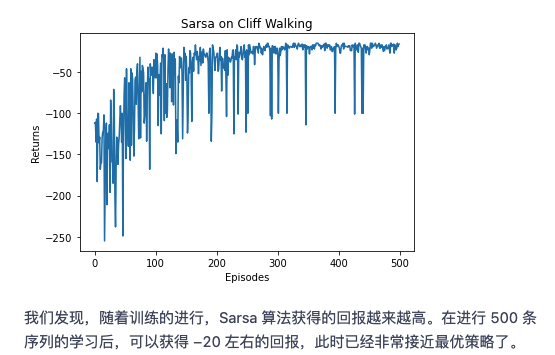

In [3]:
Image(filename="./image/sarsa_reward.png",width=600)

In [ ]:
'''
然后我们看一下 Sarsa 算法得到的策略,在各个状态下会使智能体采取什么样的动作。
'''
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')

print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# 可以发现 Sarsa 算法会采取比较远离悬崖的策略来抵达目标。

# 多步 Sarsa 算法

In [ ]:
'''
蒙特卡洛方法利用当前状态之后每一步的奖励而不使用任何价值估计，
时序差分算法只利用一步奖励和下一个状态的价值估计。
那它们之间的区别是什么呢？
'''

'''
总的来说，蒙特卡洛方法是无偏（unbiased）的，但是具有比较大的方差，
因为每一步的状态转移都有不确定性，而每一步状态采取的动作所得到的不一样的奖励最终都会加起来，
这会极大影响最终的价值估计
'''

'''
时序差分算法具有非常小的方差，因为只关注了一步状态转移，用到了一步的奖励，但是它是有偏的，
因为用到了下一个状态的价值估计而不是其真实的价值。
'''

'''
那有没有什么方法可以结合二者的优势呢？
答案是多步时序差分！

多步时序差分的意思是使用步的奖励，然后使用之后状态的价值估计。
'''



### 多步时序拆分，
用公式表示：
$G_t = r_t + γQ(s_{t+1},a_{t+1})$
 替换成：
$G_t = r_t + γr_{t+1} + ... + γ^n{Q(s_{t+n},a_{t+n})}$

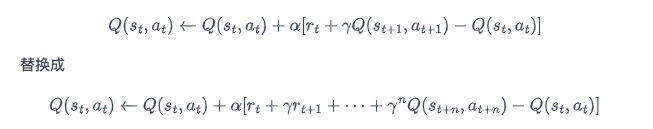

In [4]:
# Sarsa 算法中的动作价值函数:
Image(filename="./image/n-step-sarsa.png",width=600)

In [ ]:
"""n步Sarsa算法 """

class nstep_sarsa:
    def __init__(self,n,ncol,nrow,epsilon,alpha,gamma,n_action=4):
        self.Q_table = np.zeros([nrow * ncol,n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n # 采用n步sarsa算法
        self.state_list = [] # 保存之前的状态
        self.action_list = [] # 保存之前的动作
        self.reward_list = [] # 保存之前的奖励
        
    def take_action(self,state):
        if np.random.random() < self.epsilon:
            action = np.random.ranint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    # 用于打印策略,当前状态s下，每个动作的概率
    def best_action(self,state):
        # 当前状态s的最大值
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state,i]== Q_max:
                # 将最大值的动作的概率设置为1
                a[i] = 1      
        return a
    def update(self,s0,a0,r,s1,a1,done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        # 保存用于n步更新的的数据
        if len(self.state_list)==self.n:
            G = self.Q_table[s1,a1]
            for i in reversed(range(self.n)):# 执行n次计算
                # 不断向前计算每一步的回报
                G = self.gamma *G + self.reward_list[i]
                # 如果到达终止状态，最后几步虽然长度不够n步，也将其进行更新
                if done and i >0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    # 更新Q值
                    self.Q_table[s,a] +=self.alpha * (G - self.Q_table[s,a])
            # 将需要更新的状态动作从列表中删除，下次不必更新
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_liste.pop(0)
            # n步sarsa的主要更新步骤
            self.Q_table[s,a] +=self.alpha * (G - self.Q_table[s,a])
        if done: #如果到达终止状态，在开始下一条序列之前，将本次的列表清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []
        

In [ ]:
np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

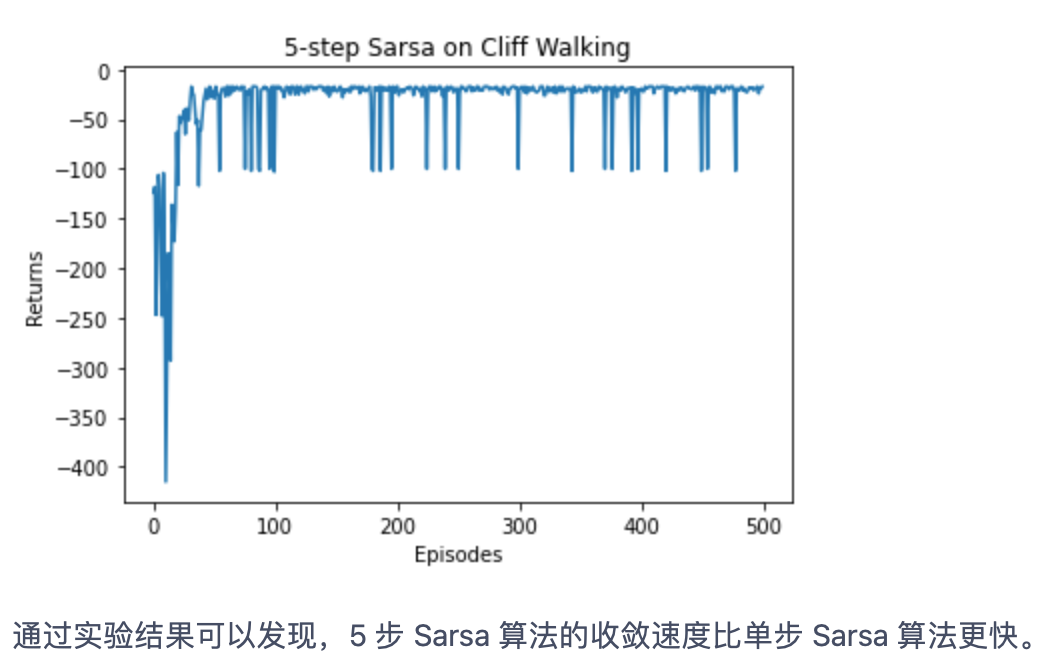

In [5]:
Image(filename="./image/n-sarsa2.png",width=600)

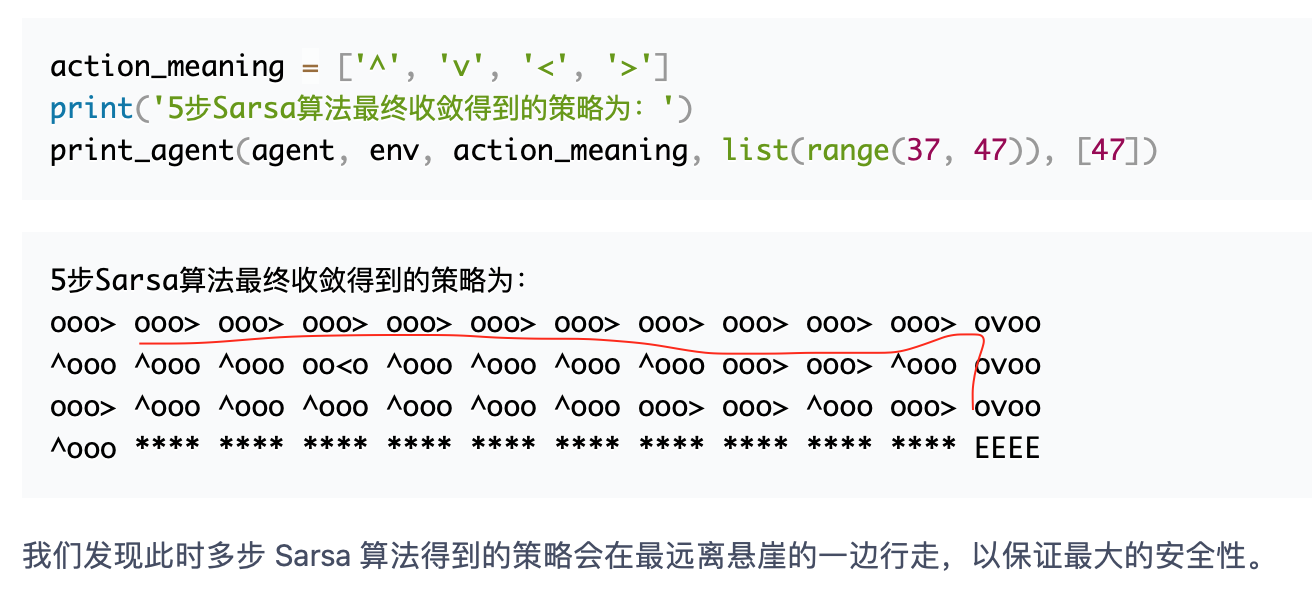

In [6]:
Image(filename="./image/nsarsa-walk.png",width=600 )

In [ ]:
'''
我们发现此时多步sarsa算法得到的策略会在远离悬崖的一边行走，以保证最大的安全性
'''

## Q-learning 是在估计$Q^*$,是离线策略算法

动作价值函数的贝尔曼方程是: $Q^*(s,a) = r(s,a) + γ\sum_{s`∈S}P(s`|s,a)max_{a`}{Q^*(s`,a`)}$

In [ ]:
'''Q-learning算法'''
class QLearning:
    def __init__(self,ncol,nrow,epsilon,alpha,gamma,n_action=4):
        self.Q_table = np.zeros([nrow * ncol,n_action]) # 初始化Q(s,a)表格
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
    def take_action(self,state):#选取下一步操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
     # 用于打印策略,当前状态s下，每个动作的概率
    def best_action(self,state):
        # 当前状态s的最大值
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state,i]== Q_max:
                # 将最大值的动作的概率设置为1
                a[i] = 1      
        return a
    
    def update(self,s0,a0,r,s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0,a0]
        self.Q_table[s0,a0] +=self.alpha * td_error

In [ ]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

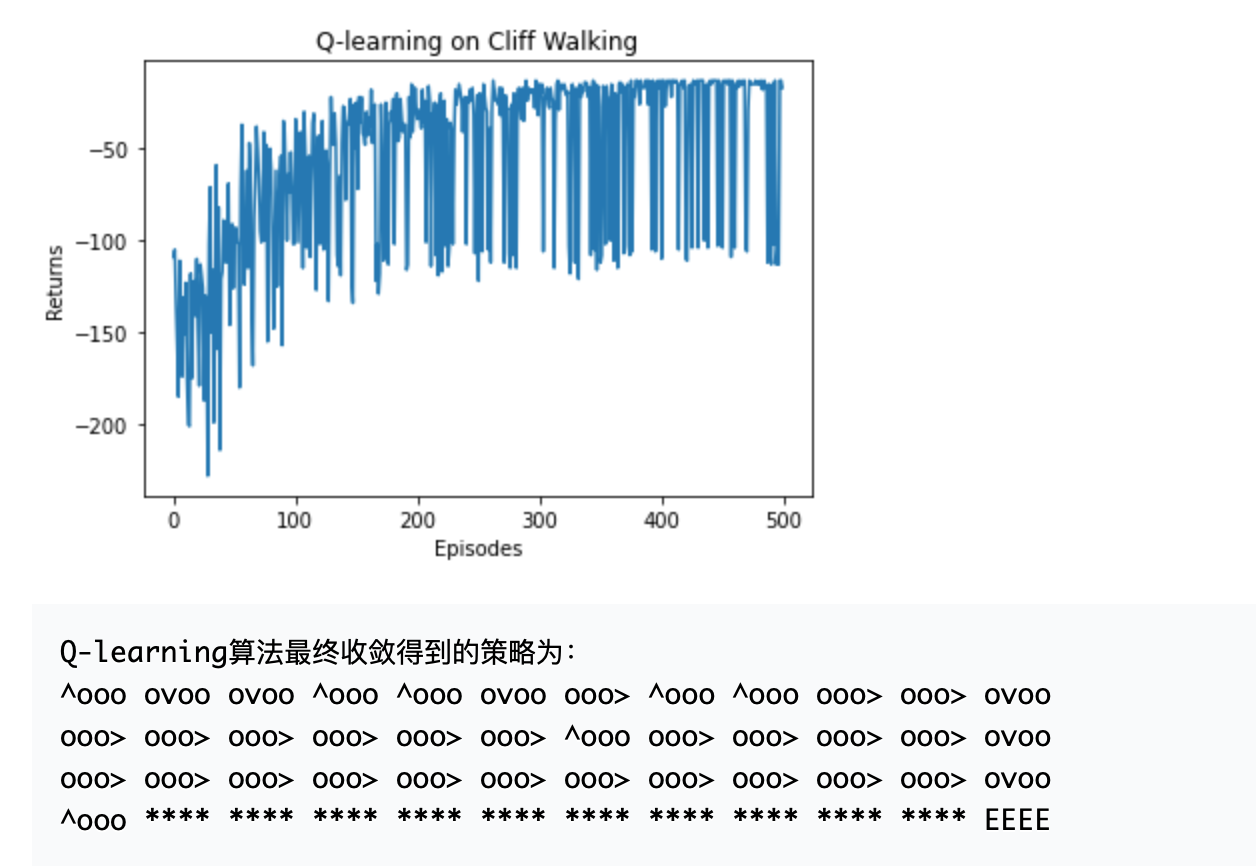

In [7]:
Image(filename="./image/qlearning.png",width=600)

In [ ]:
'''

需要注意的是，打印出来的回报是行为策略在环境中交互得到的，而不是 Q-learning 算法在学习的目标策略的真实回报。
我们把目标策略的行为打印出来后，发现其更偏向于走在悬崖边上，这与 Sarsa 算法得到的比较保守的策略相比是更优的。
但是仔细观察 Sarsa 和 Q-learning 在训练过程中的回报曲线图，
我们可以发现，在一个序列中 Sarsa 获得的期望回报是高于 Q-learning 的。
这是因为在训练过程中智能体采取基于当前Q(s,a)函数的-贪婪策略来平衡探索与利用，Q-learning 算法由于沿着悬崖边走，
会以一定概率探索“掉入悬崖”这一动作，而 Sarsa 相对保守的路线使智能体几乎不可能掉入悬崖。

'''

### Q-learning收敛性证明